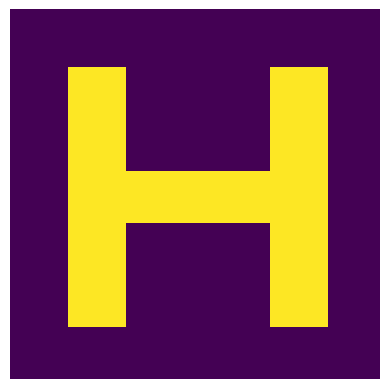

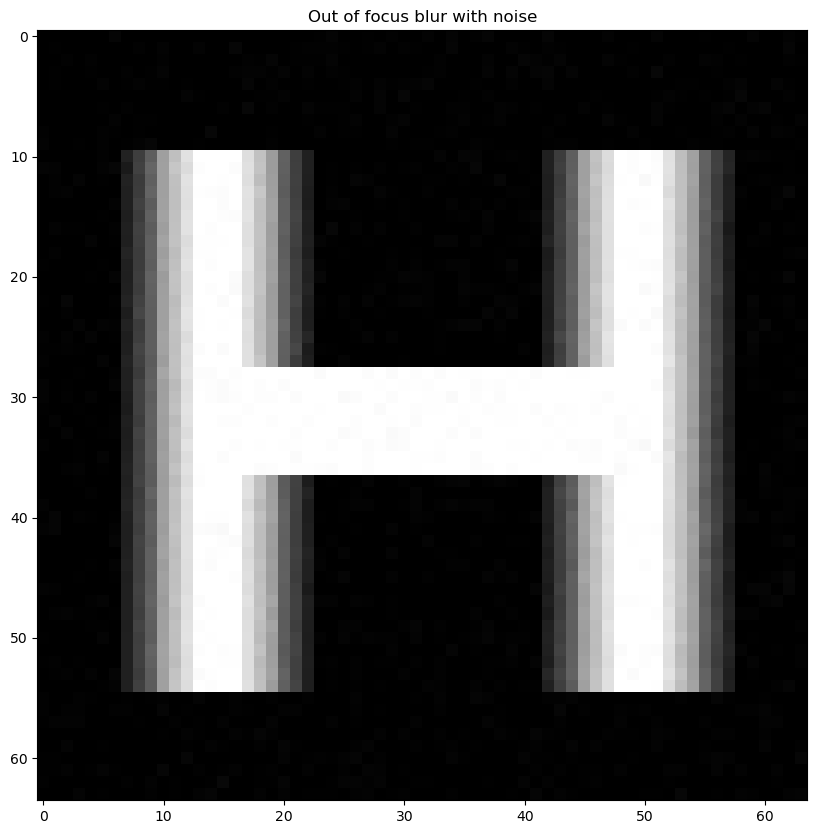

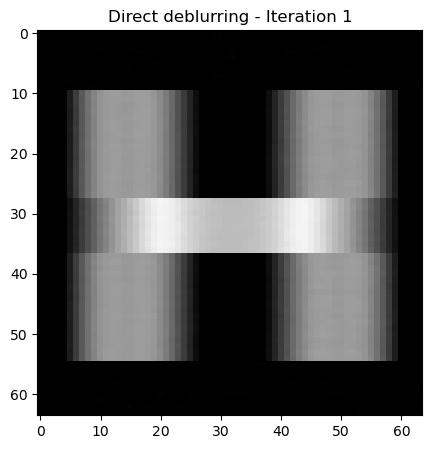

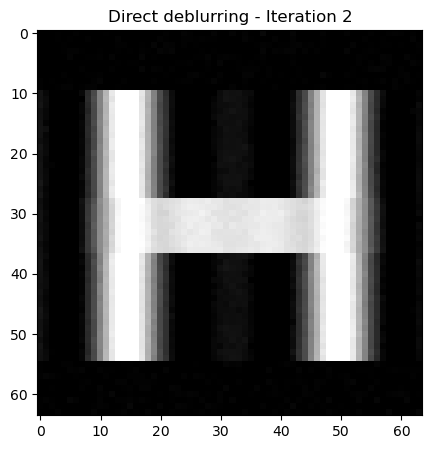

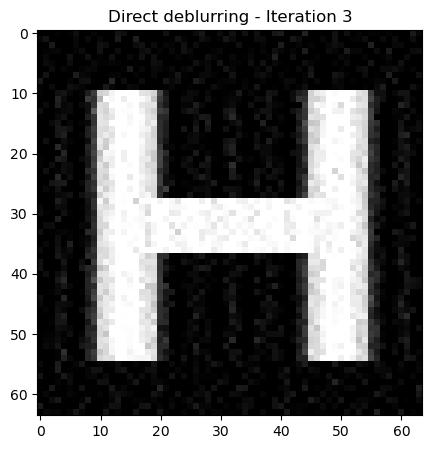

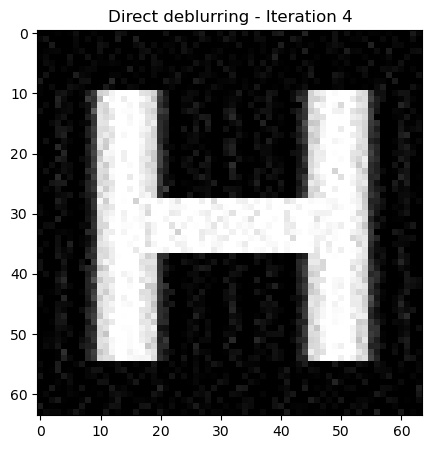

In [45]:
# -*- coding: utf-8 -*-
"""

Modified by Malena Espanol

from a copy of Image Deblurring Project.ipynb

written by Jeff Calder

"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

def vec(image):
    sh = image.shape
    return image.reshape((sh[0]*sh[1]))

def build_x_true():
    dx = 10
    dy = 10
    up_width = 10
    bar_width= 5
    size = 64

    h_im = np.zeros((size, size))
    for i in range(size):
        if i < dy or i > size-dy:
            continue
        for j in range(size):
            if j < dx or j > size - dx:
                continue
            if j < dx + up_width or j > size - dx - up_width:
                h_im[i, j] = 1
            if abs(i - size/2) < bar_width:
                h_im[i, j] = 1

    x_exact = vec(h_im)
    return x_exact
## convert a 1-d vector into a 2-d image of the given shape
    
def im(x, shape):
    return x.reshape(shape)

## display a 1-d vector as a 2-d image
def display_vec(vec, shape, scale = 1):
    image = im(vec, shape)
    plt.imshow(image, vmin=0, vmax=scale * np.max(vec), cmap='gray')
    plt.axis('off')
    plt.show()


#github = 'https://github.com/jwcalder/TestImages/raw/main/'


#image = 'cameraman.png'

#Load image
#img = plt.imread(image)

img= build_x_true()
size = 64
shape = (size, size)
pixels = shape[0] * shape[1]

Img = im(img, shape)


plt.imshow(Img)
plt.axis('off')
plt.show()



"""Let's define a function to blur the image."""

from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftshift
from scipy.optimize import minimize
from scipy.linalg import norm
import numpy as np
import math

def blur_gaussian(n,width=5):
    """Returns FFT of out of focus blur filter

    Args:
        n: dimensions of each side of the image
        width: Width of the out of focus filter
    
    Returns:
        G: Fourier transform of filter
    """

    x,y = np.mgrid[:n,:n]
    g = (x-n/2)**2 + (y-n/2)**2 < width**2
    g = g/np.sum(g)
    return fft2(fftshift(g)).real

def blur_linear(n,radius=5,angle=0):
    """Returns FFT linear/motion blur

    Args:
        n: dimensions of each side of the image
        radius: Radius of the linear blur
        angle: Angle of the linear blur; 0 is +x axis, 
               moves in anticlockwise direction
    
    Returns:
        G: Fourier transform of filter
    """
    
    p = np.zeros((n, n))

    # get center of psf
    i = math.ceil(p.shape[0] / 2)
    j = math.ceil(p.shape[1] / 2)

    for r in range(0, math.floor(radius) + 1):
        px = math.floor(r * math.cos(angle) + i) % p.shape[0]
        py = math.floor(-r * math.sin(angle) + j) % p.shape[1]
        p[py, px] = 1 / radius
    
    p = p / np.sum(p)

    return fft2(fftshift(p)).real

def blur(f,G):
    """Blurs image f with filter G

    Args:
        f: image to blur
        G: Filter 

    Returns:
        Blurred image
    """
    return ifft2(G*fft2(f)).real

"""Let's now blur an image and then deblur without any regularization. What happens when you add some noise to the blurry image, even noise that is very light and imperceptible?"""

#First get a blur filter
# G = blur_gaussian(Img.shape[0],width=5)
radius = 3
G = blur_linear(Img.shape[0], radius, angle = 0)

# plt.figure(figsize=(10,10))
# im = plt.imshow(G)
# plt.colorbar(im)
# plt.title('Direct deblurring')

#Blur the image
Img_blurred = blur(Img,G)

#Add noise
sigma = 0.01 #Try sigma=0 first, and then try sigma > 0 to add noise
Img_blurred = Img_blurred + sigma*np.random.randn(Img.shape[0],Img.shape[1])

#Show blurred and noisy image
plt.figure(figsize=(10,10))
plt.imshow(Img_blurred,cmap='gray',vmin=0,vmax=1)
plt.title('Out of focus blur with noise')

def deblur_tik(alpha, S, blurred_img):
    # S is fft2(circshift(psf))

    # phi = abs(S).^2 ./ (abs(s).^2 + alpha^2)
    # perform adjustment to values which could result in division by zero
    denominator = np.absolute(np.square(S)) + np.square(alpha)
    denominator = np.where(denominator == 0, np.finfo(float).eps, denominator)
    phi = np.divide(np.absolute(np.square(S)), denominator)

    # filter out S values according to phi 
    S_filt = np.zeros(phi.shape)
    idx = S != 0
    S_filt[idx] = np.divide(phi[idx], S[idx])
    # S_filt = np.where(idx, np.divide(phi[idx], S), 0)

    # deblur using filtered S
    X_filt = ifft2(np.multiply(fft2(blurred_img), S_filt)).real

    return X_filt

def deblur_tik_min(S):
    # error function; norm of deblurred image with blurred image
    error_function = lambda input, S, blurred_img: np.linalg.norm(deblur_tik(input[0], S, blurred_img) - Img, ord='fro')

    initial_alpha = 0.1
    # since minimizer takes in a vector, need to get first element (which will store alpha)
    result = minimize(error_function, [initial_alpha], args=(S, Img_blurred), bounds=[(0, 32)])

    # returns min alpha
    return result

def deblur_psf(psf_params, deblurred_img):
    S_i = blur_linear(Img.shape[0], psf_params[0], 0)
    return blur(deblurred_img, S_i)

def error_function(psf_params, deblurred_img, blurred_img):
    result = np.linalg.norm(deblur_psf(psf_params, deblurred_img) - blurred_img, ord='fro')
    return result

def deblur_psf_min(deblurred_img, initial_length):
    # min_{length, angle} = ||A(length, angle) x - b||
    # error_function = lambda psf_params, deblurred_img, blurred_img: np.linalg.norm(deblur_psf(psf_params, deblurred_img) - blurred_img, ord='fro')

    # specifting the solver as 'Powell' was important; otherwise it was stuck at wrong values
    result = minimize(error_function, [initial_length], args=(deblurred_img, Img_blurred), method='Powell', bounds=[(0, 16)])

    return result

# TODO:
# √ where is the code taking the longest to run
# √ create plots of convergence curves
#   √ x is iteration number, y is norm(x_i - x_true) / norm(x_true) !! relative errors
#   √ x is iteration number, y is abs(L_i - L_true) / abs(L_true)
# - save code; try with larger images (pumpkins, etc.)
# - estimate both angle and length simultaneously
# - change tikhonov with total variation regularization
# - for successive frames, use previous parameters as a feed forward
# - find video source that is blurred from CHARLOTTE

# min_alpha = deblur_tik_min(G).x[0]
# Img_deblurred = deblur_tik(min_alpha, G, Img_blurred)
# Img_deblurred = deblur_alt_min()

# plt.imshow(Img_deblurred, cmap='gray',vmin=0,vmax=1)
# plt.show()

df = pd.DataFrame(columns=['Step Number', 'Fixed A() Time Delta', 'Fixed A() Relative Error', 'Fixed x Time Delta', 'Fixed x Relative Error'])

prev_li = -1
l_i = 10
x_i = None
step_number = 1
while not math.isclose(prev_li, l_i):
    # fix theta, l for guess
    S_i = blur_linear(Img.shape[0], l_i, 0)
    start_time_1 = time.time()
    min_alpha = deblur_tik_min(S_i).x[0]
    end_time_1 = time.time()
    x_i = deblur_tik(min_alpha, S_i, Img_blurred)

    plt.figure(figsize=(5,5))
    plt.title('Direct deblurring - Iteration {}'.format(step_number))
    plt.imshow(x_i, cmap='gray',vmin=0,vmax=1)

    # fix x_i for guess
    # start time
    start_time_2 = time.time()
    next_A = deblur_psf_min(x_i, l_i)
    end_time_2 = time.time()
    prev_li = l_i
    l_i = next_A.x[0]

    row_entry = pd.Series({
        'Step Number': step_number, 
        'Fixed A() Time Delta': end_time_1 - start_time_1, 
        'Fixed A() Relative Error': norm(x_i - Img) / norm(Img), 
        'Fixed x Time Delta': end_time_2 - start_time_2, 
        'Fixed x Relative Error': abs(l_i - radius) / abs(radius)
    })

    df = pd.concat([df, row_entry.to_frame().T], ignore_index=True)
    step_number += 1

In [46]:
### interpret results
print('Total time: %.5fs' % (df['Fixed A() Time Delta'].sum() + df['Fixed x Time Delta'].sum()))
df

Total time: 0.07592s


,Step Number,Fixed A() Time Delta,Fixed A() Relative Error,Fixed x Time Delta,Fixed x Relative Error
0,1.0,0.021623,0.512823,0.012720,0.959372
1,2.0,0.004622,0.283851,0.013894,0.152251
2,3.0,0.004180,0.169541,0.004081,0.228223
3,4.0,0.004489,0.169541,0.010312,0.228223


In [49]:
import plotly.express as px

fig = px.line(df, 
    x="Step Number", 
    y=["Fixed A() Relative Error", 'Fixed x Relative Error'], 
    title='Relative Error'
)
fig.show()